# <center>Clustering Locations</center>

Say we have data with GPS co-ordinates and many other data points, what is one way to summarise the information in a way that'll help us get the most out of the data.
Heat maps and clustered maps are nice, but what if we could do more with the GPS co-ordinates.
Let's dream a little, what if there were relationships in the demographics and the other data points. e.g is customer churn influenced by region?
Here's a simple, yet powerful, way to cluster GPS locations. I came across this while working on accurately predicting ETA for motocycle deliveries in Nairobi.
For this I've used data from kaggle - https://www.kaggle.com/c/zillow-prize-1/data - Download 'properties_2016.csv'. You might want to trim it a little, or not.. Your choice. I decided to trim it down on excel to ease the load.

## Import pre-requisites

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv

## Load File

In [3]:
df = pd.read_csv('properties_2016.csv')

In [4]:
df.head(10)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN
5,10898347,NaN,NaN,NaN,0.0,0.0,4.0,7.0,NaN,NaN,...,1.0,NaN,176383.0,283315.0,2015.0,106932.0,3661.28,NaN,NaN,NaN
6,10933547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,397945.0,554573.0,2015.0,156628.0,6773.34,NaN,NaN,NaN
7,10940747,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,NaN,101998.0,688486.0,2015.0,586488.0,7857.84,NaN,NaN,NaN
8,10954547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
9,10976347,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,218440.0,261201.0,2015.0,42761.0,4054.76,NaN,NaN,NaN


## Remove rows where the Longitude and/or Latitude have null values 
--- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html---

- axis : {0 or ‘index’, 1 or ‘columns’}, default 0
    - 0, or ‘index’ : Drop rows which contain missing values.
    - 1, or ‘columns’ : Drop columns which contain missing value.

- how : {‘any’, ‘all’}, default ‘any’
    - how ='any' - If any NA values are present, drop that row or column. 
    - how = 'all' - If all values are NA, drop that row or column.
    
- subset : array-like, optional
    - Labels along other axis to consider, e.g. if you are dropping rows these would be a list of columns to include.
    
- inplace : bool, default False
    - If True, do operation inplace and return None.

In [5]:
df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)

In [8]:
# Variable with the Longitude and Latitude
X=df.loc[:,['parcelid','latitude','longitude']]

In [9]:
X.head(10)

,parcelid,latitude,longitude
0,10754147,34144442.0,-118654084.0
1,10759547,34140430.0,-118625364.0
2,10843547,33989359.0,-118394633.0
3,10859147,34148863.0,-118437206.0
4,10879947,34194168.0,-118385816.0
5,10898347,34171873.0,-118380906.0
6,10933547,34131929.0,-118351474.0
7,10940747,34171345.0,-118314900.0
8,10954547,34218210.0,-118331311.0
9,10976347,34289776.0,-118432085.0


## Exploration
Let's Explore the data a little before going to K-Means

# Create an elbow curve to select the optimal number of clusters

K-means is somewhat naive - it clusters the data into k clusters, even if k is not the right number of clusters to use. When we come to clustering, it's hard to know how many clusters are optimal… In our dataset, how many clusters are optimal i.e. make sense, we don't want to guess now do we? Therefore, when using k-means clustering, we need a way to determine whether we are using the right number of clusters.


One method to validate the number of clusters is the elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10), and for each value of k calculate the Sum of Squared Errors (SSE).

When K increases, the centroids are closer to the clusters centroids. The improvements will decline rapidly at some point, creating the elbow shape. That is the optimal value for K.

This might take a while.. Stretch a little.

In [10]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

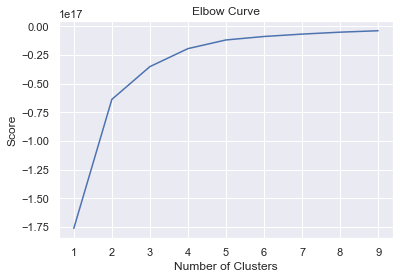

In [11]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

## Clustering using K-Means and Assigning Clusters to our Data

Let's look at some parameters first.
Link - https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Parameters
    n_clusters : int, optional, default: 8
                The number of clusters to form as well as the number of centroids to generate.
                
    init : {‘k-means++’, ‘random’ or an ndarray}
            Method for initialization, defaults to ‘k-means++’:
            ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 
            ‘random’: choose k observations (rows) at random from data for the initial centroids.
             If an ndarray is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.

### <center> Let's get into it. </center>

In [18]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X) # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.

labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

X.head(10)

,parcelid,latitude,longitude,cluster_label
0,10754147,34144442.0,-118654084.0,0
1,10759547,34140430.0,-118625364.0,0
2,10843547,33989359.0,-118394633.0,2
3,10859147,34148863.0,-118437206.0,2
4,10879947,34194168.0,-118385816.0,2
5,10898347,34171873.0,-118380906.0,2
6,10933547,34131929.0,-118351474.0,2
7,10940747,34171345.0,-118314900.0,2
8,10954547,34218210.0,-118331311.0,2
9,10976347,34289776.0,-118432085.0,2


## Visualise Reults
Let's visualize the results by plotting the data colored by these labels. 
We will also plot the cluster centers as determined by the k-means estimator:

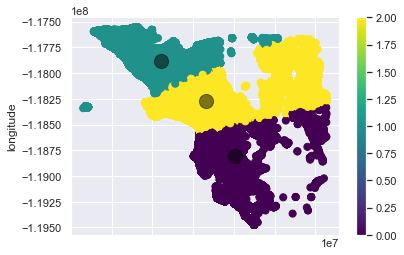

In [19]:
X.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Merge Results with the all of your data
We have to merge our existing data to include the clusters so we can do more analysis. We have two variables containing our data, 'df' and 'X'. Let's see what they look like before.

In [20]:
df.head(5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [21]:
X.head(5)

,parcelid,latitude,longitude,cluster_label
0,10754147,34144442.0,-118654084.0,0
1,10759547,34140430.0,-118625364.0,0
2,10843547,33989359.0,-118394633.0,2
3,10859147,34148863.0,-118437206.0,2
4,10879947,34194168.0,-118385816.0,2


Let's remove the longitude and latitudes from 'X' since they already exist on 'df'.
If we don't remove the longitude and latitude column, we'll have 2 other columns created for longitude and latitude in our data frame. We don't want that.

In [22]:
X = X[['parcelid','cluster_label']]
X.head(5)

,parcelid,cluster_label
0,10754147,0
1,10759547,0
2,10843547,2
3,10859147,2
4,10879947,2


In [23]:
clustered_data = df.merge(X, left_on='parcelid', right_on='parcelid')

clustered_data.head(5)

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,cluster_label
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN,0
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN,0
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN,2
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN,2
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN,2


## Export the Data Frame to a CSV

Fortunately there's a 'pandas.DataFrame.to_csv' function.

In [15]:
clustered_data.to_csv ('clustered_data.csv', index=None, header = True)

## <center> Bonus - How to get the Centers. </center>
These are the centers of the clusters that have been created. i.e the centers of the regions.

In [16]:
centers = kmeans.cluster_centers_
print(centers)

[[ 3.39345671e+07 -1.17865845e+08]
 [ 3.42500270e+07 -1.19211530e+08]
 [ 3.39667150e+07 -1.18265894e+08]
 [ 3.44833592e+07 -1.18322645e+08]
 [ 3.42620732e+07 -1.18985760e+08]]


## What Next?
Having clustered the locations, we can now have a different perspective of the data we have.
<h1><center>Thank you for reading and ... Good Luck!</center></h1>